In [1]:
from pathlib import Path
import math
import sys
import yaml
import time
import os
import copy
import math

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import lines
from geopy.geocoders import GoogleV3, Nominatim
from mpl_toolkits.axes_grid1 import make_axes_locatable

DIR = Path('..')
sys.path.insert(0, str(DIR))
from SCanalyzer import SCanalyzer
from SCanalyzer.busSim import BusSim, Config
from SCanalyzer.busSim.manager import managerFactory
from SCanalyzer.gtfs_edit import edit_double
from SCanalyzer.util import findEPSG
from SCanalyzer.busSim.manager import LocalManager
from pyproj import Transformer

import warnings
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

%matplotlib inline

/var/folders/n3/pv33hjv54ylc6fhldnnb8dgw0000gn/T/ipykernel_29949/1153132976.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def get_yelp_api_key():
    with open("../config.yml", 'r') as yml:
        cfg = yaml.safe_load(yml)
        return cfg["yelp"]["api_key"]

def plot_background(crs):
    background_path = os.path.join('..', 'data', 'plot', 'background')
    city = gpd.read_file(os.path.join(background_path, "madison-meter-shp")).to_crs(crs)
    lakes = gpd.read_file(os.path.join(background_path, "water-meter-shp")).to_crs(crs)
    street = gpd.read_file(os.path.join(background_path, "street-meter-shp")).to_crs(crs)
    # city = gpd.read_file(background_path + "madison-shp")
    # lakes = gpd.read_file(background_path + "water-shp")
    # street = gpd.read_file(background_path + "street-shp")

    ax = city.plot(color="lightgray", alpha=.2, figsize=(12, 12), zorder=2)
    lakes.plot(color="lightblue", ax=ax, zorder=1, alpha=0.8)
    street.plot(color="darkgray", alpha = .5, ax=ax, zorder=3)
    return ax

cache = {}
def geocode(addr):
    # if not "madison" in addr.lower():
    #     addr += ", Madison WI"
    if not addr in cache:
        cache[addr] = geolocator.geocode(addr)
    return cache[addr]

def flatten(s):
    return gpd.GeoDataFrame({"geometry": gpd.GeoSeries([s.unary_union])})

def get_sigmoid(x):
    return 1/(1+math.e**(-x)) - 0.5

def get_score(area, banks=0, clinics=0, dentists=0, hospitals=0, supermarkets=0):
    # y = sqrt(x), sigmoid, saturated functions
    score = get_sigmoid(banks) + get_sigmoid(clinics) + get_sigmoid(hospitals) + get_sigmoid(dentists) + get_sigmoid(supermarkets)
    return score

In [3]:
DATA_PATH = "../data/mmt_gtfs.zip"
OUT_PATH = "/tmp/output"
DAY = "monday"
START_TIME = "07:00:00"
ELAPSE_TIME = "00:30:00"
AVG_WALKING_SPEED = 1.4 # 1.4 meters per second
MAX_WALKING_MIN = 10

api_key = 'ZsHZFGtKEZeOOXhTne98eErmfd6BfNTm9GqO2S6inSnWzDwtgC2sEauXcB-8zUna_lXZEal4jsW_St6O0OQOcuNvifrr6uqNYmjFXW-FyVKvaMyczbihWELI80tjYHYx'
gtfo = SCanalyzer(DATA_PATH)
census_gdf = gtfo.load_census()
services_gdf = gtfo.load_yelp(api_key=api_key)

Getting geodataframe for tracts from Tigerweb:
https://tigerweb.geo.census.gov/arcgis/rest/services/Generalized_ACS2019/Tracts_Blocks/MapServer/4/query?geometry=-9952445.66%2C5324491.94&geometryType=esriGeometryPoint&spatialRel=esriSpatialRelIntersects&distance=19757.96&units=esriSRUnit_Meter&outFields=STATE%2CCOUNTY%2CTRACT%2CBLKGRP&returnGeometry=true&returnTrueCurves=false&returnIdsOnly=false&returnCountOnly=false&returnZ=false&returnM=false&returnDistinctValues=false&returnExtentOnly=false&featureEncoding=esriDefault&f=geojson
Getting demographics data from Census.gov, this may take a couple minutes...
Unexpected err=KeyError('businesses')
Unexpected err=KeyError('businesses')
Unexpected err=KeyError('businesses')
Unexpected err=KeyError('businesses')


In [4]:
background_path = os.path.join('..', 'data', 'plot', 'background')
city = gpd.read_file(os.path.join(background_path, "madison-meter-shp")).to_crs(4326)
# lakes = gpd.read_file(os.path.join(background_path, "Rivers.zip")).to_crs(4326)
# street = gpd.read_file(os.path.join(background_path, "Roads.zip")).to_crs(4326)
max_lon = city.bounds.maxx.max()
min_lon = city.bounds.minx.min()
max_lat = city.bounds.maxy.max()
min_lat = city.bounds.miny.min()

geolocator = Nominatim(user_agent="wisc_bazarr_demo")
manager = LocalManager(DATA_PATH, OUT_PATH, None)
busSim = BusSim(manager, DAY, START_TIME, ELAPSE_TIME, AVG_WALKING_SPEED, MAX_WALKING_MIN)

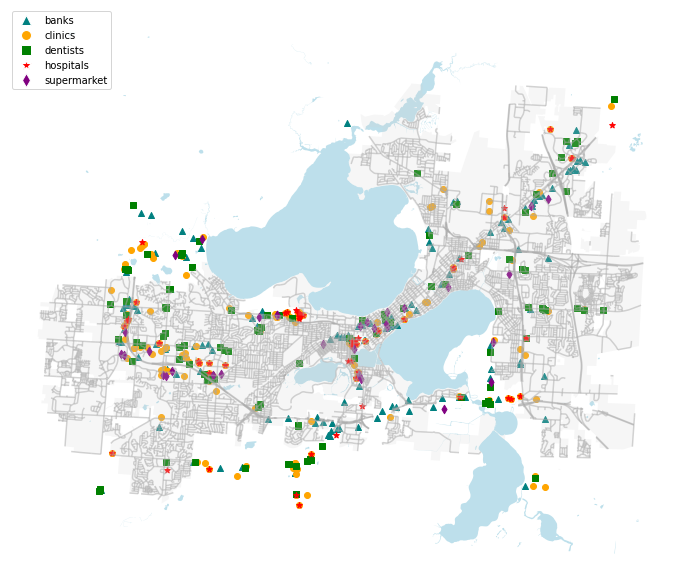

In [5]:
temp_df = services_gdf.apply(copy.deepcopy)

ax = plot_background(3174)

epsg = 3174
transformer = Transformer.from_crs(4326, epsg)
stop_x, stop_y = transformer.transform(
            temp_df['latitude'], temp_df['longitude'])
temp_df['stop_x'], temp_df['stop_y'] = stop_x, stop_y
temp_df = temp_df[(temp_df['latitude'] < max_lat) & (temp_df['latitude'] > min_lat) & (temp_df['longitude'] < max_lon) & (temp_df['longitude'] > min_lon)]
banks = temp_df[temp_df['service'] == 'banks']
clinics = temp_df[temp_df['service'] == 'clinics']
dentists = temp_df[temp_df['service'] == 'dentists']
hospitals = temp_df[temp_df['service'] == 'hospitals']
supermarket = temp_df[temp_df['service'] == 'supermarket']
banks = gpd.GeoDataFrame(
    banks['service'], geometry=gpd.points_from_xy(banks.stop_x, banks.stop_y), crs="EPSG:"+str(epsg))
clinics = gpd.GeoDataFrame(
    clinics['service'], geometry=gpd.points_from_xy(clinics.stop_x, clinics.stop_y), crs="EPSG:"+str(epsg))
dentists = gpd.GeoDataFrame(
    dentists['service'], geometry=gpd.points_from_xy(dentists.stop_x, dentists.stop_y), crs="EPSG:"+str(epsg))
hospitals = gpd.GeoDataFrame(
    hospitals['service'], geometry=gpd.points_from_xy(hospitals.stop_x, hospitals.stop_y), crs="EPSG:"+str(epsg))
supermarket = gpd.GeoDataFrame(
    supermarket['service'], geometry=gpd.points_from_xy(supermarket.stop_x, supermarket.stop_y), crs="EPSG:"+str(epsg))
banks.plot(ax=ax, color='teal', marker='^')
clinics.plot(ax=ax, color='orange', marker='o')
dentists.plot(ax=ax, color='green', marker='s')
hospitals.plot(ax=ax, color='red', marker='*')
supermarket.plot(ax=ax, color='purple', marker='d')

lineslist = []
lineslist.append(lines.Line2D([],[],color="white", markerfacecolor = "teal", marker = "^", markersize=10, label = "banks"))
lineslist.append(lines.Line2D([],[],color="white", markerfacecolor = "orange", marker = "o", markersize=10, label = "clinics"))
lineslist.append(lines.Line2D([],[],color="white", markerfacecolor = "green", marker = "s", markersize=10, label = "dentists"))
lineslist.append(lines.Line2D([],[],color="white", markerfacecolor = "red", marker = "*", markersize=10, label = "hospitals"))
lineslist.append(lines.Line2D([],[],color="white", markerfacecolor = "purple", marker = "d", markersize=10, label = "supermarket"))
ax.legend(handles = lineslist, loc="upper left",prop={"size": 10})
# ax.legend(handles = lineslist, bbox_to_anchor=(1.00, 1.00), loc="upper left",prop={"size": 10})

ax.set_axis_off()

In [6]:
# the number of each building in each census block
city = city.to_crs(epsg)

new_census = census_gdf.to_crs(epsg).intersection(city.unary_union)
census_union = gpd.GeoDataFrame(geometry=new_census, crs=epsg)
# census_union = pd.concat([census_union, new_census.iloc[:, -5:]], axis=1)
new_census = census_union[~census_union['geometry'].is_empty].copy(True)
new_census['banks'] = 0
new_census['clinics'] = 0
new_census['dentists'] = 0
new_census['hospitals'] = 0
new_census['supermarket'] = 0
for idx, row in new_census.iterrows():
    for _, service in temp_df.iterrows():
        # if row['miny'] <= service['latitude'] <= row['maxy'] and row['minx'] <= service['longitude'] <= row['maxx']:
        if row.geometry.contains(Point(service.stop_x, service.stop_y)):
            new_census.loc[idx, service['service']] += 1

In [7]:
# city = city.to_crs(epsg)

# census_union = census_gdf.to_crs(epsg).intersection(city.unary_union)
# census_union = gpd.GeoDataFrame(geometry=census_union, crs=epsg)
# census_union = pd.concat([census_union, new_census.iloc[:, -5:]], axis=1)
# new_census = census_union[~census_union['geometry'].is_empty].copy(True)

new_census['score'] = 0
for idx, row in new_census.iterrows():
    new_census.loc[idx, 'score'] = get_score(0, row['banks'], row['clinics'], row['dentists'], row['hospitals'], row['supermarket'])

In [8]:
# [(p.y, p.x) for p in census_union[~census_union.centroid.is_empty].centroid.to_crs(4326)]
new_census['score'] != 0

1      False
2       True
3      False
4       True
5       True
       ...  
266     True
267     True
268    False
269     True
275    False
Name: score, Length: 194, dtype: bool

In [107]:
new_census_sorted = new_census[new_census['score'] != 0].sort_values('score')
length = len(new_census_sorted)
points_low = new_census_sorted.head(math.floor(length/2))
points_high = new_census_sorted.tail(math.ceil(length/2))

In [108]:
def flatten(s, crs):
    return gpd.GeoDataFrame({"geometry": gpd.GeoSeries([s.unary_union]), 'crs': crs})

def get_area_score(start_points, bussim, crs, census):
    # run busSim from centroid, return the scroe from the result.
    scores = []
    for index, start in enumerate(start_points):
        gdf = bussim.get_gdf(start_point=start)
        busSim.clear_graph()
        if gdf is None:
            scores.append(0)
            continue
        gdf = gdf.to_crs(crs)
        bubble = flatten(gdf.geometry, crs)
        census2 = census.to_crs(crs).intersection(bubble.unary_union)
        census2 = gpd.GeoDataFrame(geometry=census2, crs=crs)
        census2['score'] = census['score']
        scores.append(census2[~census2['geometry'].is_empty]['score'].sum())
    return scores

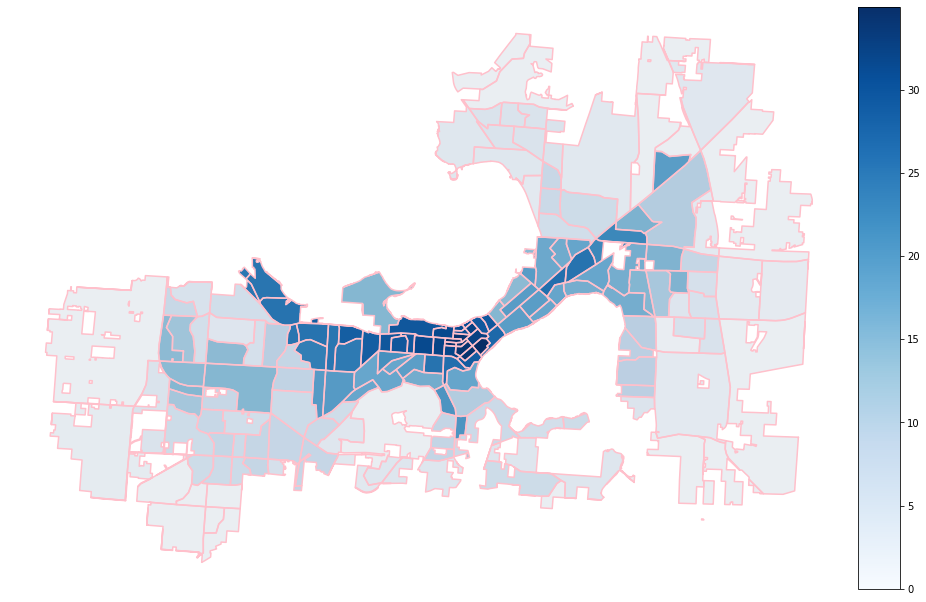

In [109]:
# census boundary

city = city.to_crs(epsg)
# lakes = lakes.to_crs(epsg)
# street = street.to_crs(epsg)
# ax = lakes.boundary.plot(color="lightblue", zorder=1, linewidth=2, figsize=(16, 16))
# lakes.plot(color="lightblue", ax=ax, alpha=0.2, zorder=1)
ax = city.plot(color="black", alpha=0.05, zorder=2, figsize=(16, 16))
# street.plot(color="black", alpha=0.3, ax=ax, zorder=3)

# intersect census_gdf with city, then add the score into the result_gdf
census_union = census_gdf.to_crs(epsg).intersection(city.unary_union)
census_union = gpd.GeoDataFrame(geometry=census_union, crs=epsg)
geometry_for_union = census_union[~census_union.centroid.is_empty]
start_points = [(p.y, p.x) for p in geometry_for_union.centroid.to_crs(4326)]
scores = get_area_score(start_points, busSim, epsg, new_census)
# census_union['score'] = new_census['score']
census_union = gpd.GeoDataFrame({
    'geometry': geometry_for_union['geometry'],
    'score': scores
})

# vertically align the plot axes and the legend axes
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# draw the census, the higher the score, the deepred the color
census_union[~census_union['geometry'].is_empty].plot(ax=ax, column='score', cmap='Blues', legend=True, cax=cax)
census_union[~census_union['geometry'].is_empty].boundary.plot(ax=ax, color='pink')

# banks.intersection(city.unary_union).plot(ax=ax, color='teal', marker='^', zorder=4)
# clinics.intersection(city.unary_union).plot(ax=ax, color='orange', marker='o', zorder=4)
# dentists.intersection(city.unary_union).plot(ax=ax, color='green', marker='s', zorder=4)
# hospitals.intersection(city.unary_union).plot(ax=ax, color='red', marker='*', zorder=4)
# supermarket.intersection(city.unary_union).plot(ax=ax, color='purple', marker='d', zorder=4)

# ax.legend(handles = lineslist, loc="upper left",prop={"size": 10})
# ax.legend(handles = lineslist, bbox_to_anchor=(1.00, 1.00), loc="upper left",prop={"size": 10})

ax.set_axis_off()

In [110]:
new_census

,geometry,banks,clinics,dentists,hospitals,supermarket,score
1,"MULTIPOLYGON (((584093.773 731626.310, 584093....",0,0,0,0,0,0.000000
2,"POLYGON ((586884.439 731471.939, 586940.149 73...",0,1,1,0,2,0.842914
3,"MULTIPOLYGON (((586676.115 728976.880, 586747....",0,0,0,0,0,0.000000
4,"POLYGON ((588206.728 732877.237, 588826.112 73...",0,1,0,0,0,0.231059
5,"POLYGON ((588586.267 733052.060, 588846.295 73...",0,1,0,0,0,0.231059
...,...,...,...,...,...,...,...
266,"POLYGON ((604638.871 733990.776, 604514.148 73...",0,1,0,0,1,0.462117
267,"POLYGON ((605593.582 737008.830, 605730.959 73...",0,1,1,0,0,0.462117
268,"POLYGON ((606919.092 734625.461, 606950.664 73...",0,0,0,0,0,0.000000
269,"MULTIPOLYGON (((605664.964 744348.185, 606024....",2,6,6,3,0,1.828426


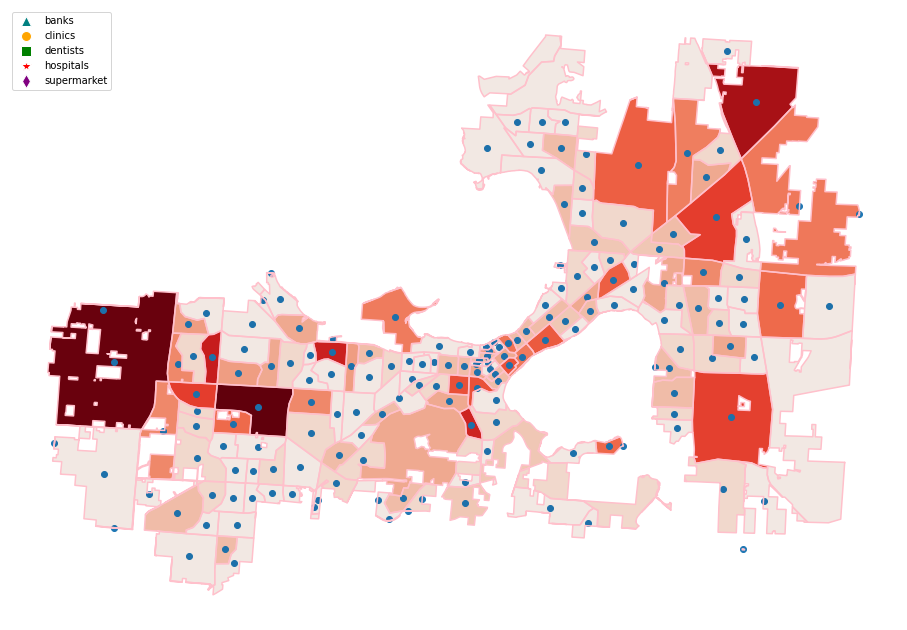

In [111]:
# census centroid

ax = city.plot(color="black", alpha=0.05, zorder=2, figsize=(16, 16))

# intersect census_gdf with city, then add the score into the result_gdf
census_union = census_gdf.to_crs(epsg).intersection(city.unary_union)
census_union = gpd.GeoDataFrame(geometry=census_union, crs=epsg)
census_union['score'] = new_census['score']

# draw the census, the higher the score, the deepred the color
census_union[~census_union['geometry'].is_empty].plot(ax=ax, column='score', cmap='Reds')
census_union[~census_union['geometry'].is_empty].boundary.plot(ax=ax, color='pink')
census_union.centroid.intersection(city.unary_union).plot(ax=ax)

ax.legend(handles = lineslist, loc="upper left",prop={"size": 10})
# ax.legend(handles = lineslist, bbox_to_anchor=(1.00, 1.00), loc="upper left",prop={"size": 10})

ax.set_axis_off()